Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 model_2 (Functional)        (None, 128)                  7391744   ['input_5[0][0]',             
                                                                     'input_6[0][0]']             
                                                                                                  
 Distance (Lambda)           (None, 128)                  0         ['model_2[0][0]',       

c:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully.
155/155 [==============================] - 15s 95ms/step
Accuracy: 0.9846
False Acceptance Rate (FAR): 0.0071
False Rejection Rate (FRR): 0.8200
Equal Error Rate (EER): 0.1492 (Threshold: 0.0000)


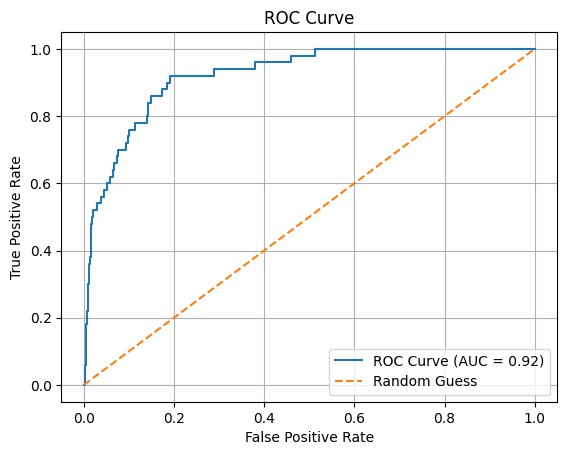

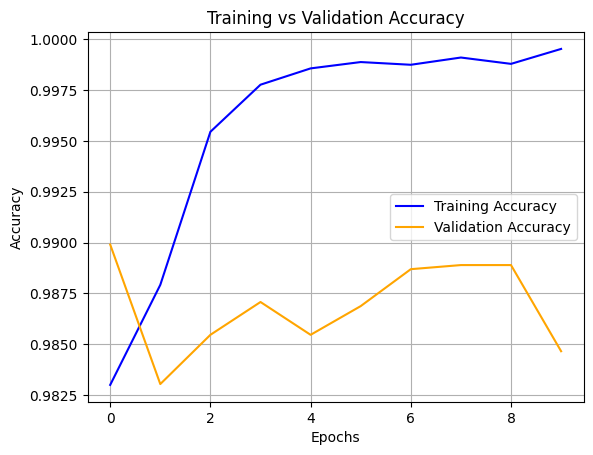

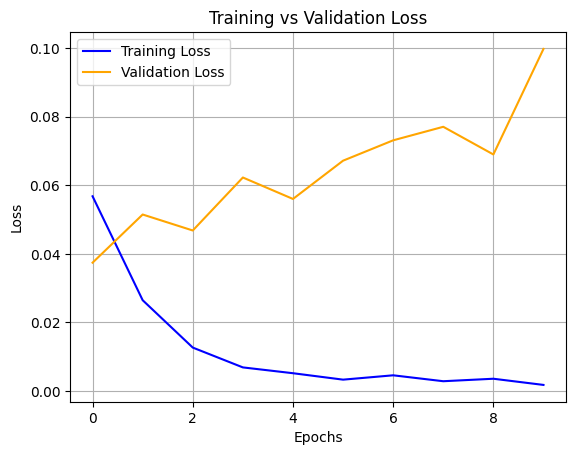

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Dataset loading and splitting
def load_and_split_dataset(dataset_path, img_size=(128, 128)):
    train_images, train_labels = [], []
    test_images, test_labels = [], []

    user_folders = sorted(os.listdir(dataset_path))  # Ensure consistent order

    for folder in user_folders:
        folder_path = os.path.join(dataset_path, folder)
        images = []

        for img_name in sorted(os.listdir(folder_path)):  # Sort images for consistent splitting
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, img_size)
            images.append(img)

        # Use the first 6 images for training and the last 2 for testing
        train_images.extend(images[:6])
        train_labels.extend([folder] * 6)  # Use subdirectory name as label
        test_images.extend(images[6:])
        test_labels.extend([folder] * 2)  # Use subdirectory name as label

    train_images = np.array(train_images) / 255.0  # Normalize
    test_images = np.array(test_images) / 255.0  # Normalize
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)

    return train_images, train_labels, test_images, test_labels

dataset_path = "CrossMatch_Sample_DB"  # Replace with your dataset path
train_images, train_labels, test_images, test_labels = load_and_split_dataset(dataset_path)

# Pair creation for Siamese Network
def create_pairs_fixed(images, labels):
    pairs, pair_labels = [], []
    unique_labels = np.unique(labels)

    # Positive pairs
    for label in unique_labels:
        idx = np.where(labels == label)[0]
        for i in range(len(idx)):
            for j in range(i + 1, len(idx)):
                pairs.append([images[idx[i]], images[idx[j]]])
                pair_labels.append(1)

    # Negative pairs
    for label1 in unique_labels:
        for label2 in unique_labels:
            if label1 >= label2:
                continue
            idx1 = np.where(labels == label1)[0]
            idx2 = np.where(labels == label2)[0]
            for i in range(len(idx1)):
                for j in range(len(idx2)):
                    pairs.append([images[idx1[i]], images[idx2[j]]])
                    pair_labels.append(0)

    return np.array(pairs), np.array(pair_labels)

# Create pairs
train_pairs, train_pair_labels = create_pairs_fixed(train_images, train_labels)
test_pairs, test_pair_labels = create_pairs_fixed(test_images, test_labels)

x_train_1 = train_pairs[:, 0].reshape(-1, 128, 128, 1)
x_train_2 = train_pairs[:, 1].reshape(-1, 128, 128, 1)
x_test_1 = test_pairs[:, 0].reshape(-1, 128, 128, 1)
x_test_2 = test_pairs[:, 1].reshape(-1, 128, 128, 1)

y_train = train_pair_labels
y_test = test_pair_labels
# Pair creation for Siamese Network with balanced positive and negative pairs
# def create_balanced_pairs(images, labels):
#     pairs, pair_labels = [], []
#     unique_labels = np.unique(labels)

#     # Positive pairs
#     for label in unique_labels:
#         idx = np.where(labels == label)[0]
#         for i in range(len(idx)):
#             for j in range(i + 1, len(idx)):
#                 pairs.append([images[idx[i]], images[idx[j]]])
#                 pair_labels.append(1)

#     # Negative pairs (sampled to match the number of positive pairs)
#     num_positive_pairs = len(pair_labels)
#     negative_pairs_count = 0

#     while negative_pairs_count < num_positive_pairs:
#         label1, label2 = np.random.choice(unique_labels, size=2, replace=False)
#         idx1 = np.random.choice(np.where(labels == label1)[0])
#         idx2 = np.random.choice(np.where(labels == label2)[0])

#         pairs.append([images[idx1], images[idx2]])
#         pair_labels.append(0)
#         negative_pairs_count += 1

#     return np.array(pairs), np.array(pair_labels)

# # Create balanced pairs
# train_pairs, train_pair_labels = create_balanced_pairs(train_images, train_labels)
# test_pairs, test_pair_labels = create_balanced_pairs(test_images, test_labels)

# x_train_1 = train_pairs[:, 0].reshape(-1, 128, 128, 1)
# x_train_2 = train_pairs[:, 1].reshape(-1, 128, 128, 1)
# x_test_1 = test_pairs[:, 0].reshape(-1, 128, 128, 1)
# x_test_2 = test_pairs[:, 1].reshape(-1, 128, 128, 1)

# y_train = train_pair_labels
# y_test = test_pair_labels

# Rest of the Siamese network and evaluation code remains unchanged



# Siamese network architecture
def build_siamese_network(input_shape):
    input = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu')(input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    return Model(input, x)

input_shape = (128, 128, 1)
base_network = build_siamese_network(input_shape)

input1 = layers.Input(shape=input_shape)
input2 = layers.Input(shape=input_shape)

features1 = base_network(input1)
features2 = base_network(input2)

distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]),
                          output_shape=(128,),
                          name="Distance")([features1, features2])
output = layers.Dense(1, activation='sigmoid')(distance)

siamese_model = Model(inputs=[input1, input2], outputs=output)
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
siamese_model.summary()

# Train the Siamese Network
history = siamese_model.fit(
    [x_train_1, x_train_2], y_train,
    validation_data=([x_test_1, x_test_2], y_test),
    batch_size=64,
    epochs=10
)

# Save the trained model
siamese_model.save("siamese_model.h5")
print("Model saved successfully.")


# Evaluate FAR, FRR, and EER
def calculate_far_frr(y_true, y_pred, threshold):
    y_pred_binary = (y_pred >= threshold).astype(int)
    false_acceptances = np.sum((y_pred_binary == 1) & (y_true == 0))
    false_rejections = np.sum((y_pred_binary == 0) & (y_true == 1))
    total_negatives = np.sum(y_true == 0)
    total_positives = np.sum(y_true == 1)

    far = false_acceptances / total_negatives if total_negatives > 0 else 0
    frr = false_rejections / total_positives if total_positives > 0 else 0

    return far, frr

def calculate_eer(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
    return eer, eer_threshold

# Get predictions
y_pred = siamese_model.predict([x_test_1, x_test_2]).flatten()

# Calculate metrics
accuracy = np.mean((y_pred >= 0.5) == y_test)
far, frr = calculate_far_frr(y_test, y_pred, threshold=0.5)
eer, eer_threshold = calculate_eer(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"False Acceptance Rate (FAR): {far:.4f}")
print(f"False Rejection Rate (FRR): {frr:.4f}")
print(f"Equal Error Rate (EER): {eer:.4f} (Threshold: {eer_threshold:.4f})")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# Plot training vs validation graph
def plot_train_val_graph(history):
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Assuming `history` is the training history object
plot_train_val_graph(history)

25/25 [==============================] - 2s 96ms/step


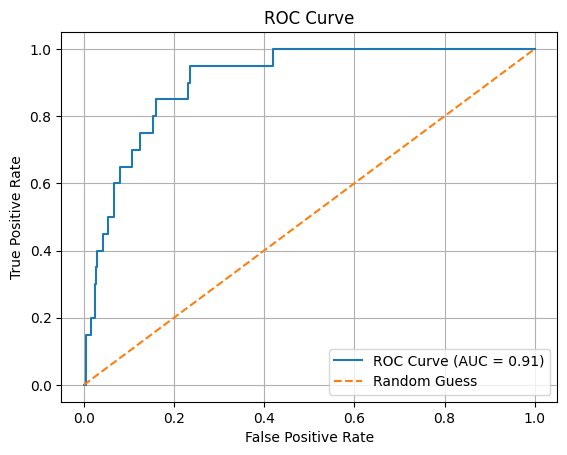

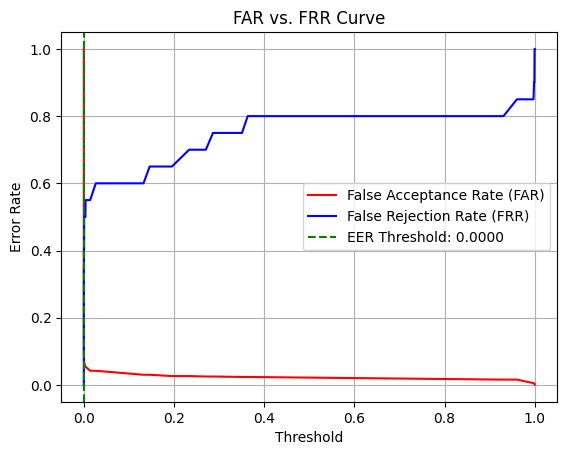

Equal Error Rate (EER): 0.1592 (Threshold: 0.0000)


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def calculate_far_frr(y_true, y_pred, threshold):
    y_pred_binary = (y_pred >= threshold).astype(int)
    false_acceptances = np.sum((y_pred_binary == 1) & (y_true == 0))
    false_rejections = np.sum((y_pred_binary == 0) & (y_true == 1))
    total_negatives = np.sum(y_true == 0)
    total_positives = np.sum(y_true == 1)

    far = false_acceptances / total_negatives if total_negatives > 0 else 0
    frr = false_rejections / total_positives if total_positives > 0 else 0

    return far, frr

def calculate_eer(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
    return eer, eer_threshold, fpr, fnr, thresholds

# Get predictions
y_pred = siamese_model.predict([x_test_1, x_test_2]).flatten()

# Calculate metrics
eer, eer_threshold, fpr, fnr, thresholds = calculate_eer(y_test, y_pred)
far_values = []
frr_values = []

for threshold in thresholds:
    far, frr = calculate_far_frr(y_test, y_pred, threshold)
    far_values.append(far)
    frr_values.append(frr)

# Plot ROC curve
roc_auc = auc(fpr, 1 - fnr)
plt.figure()
plt.plot(fpr, 1 - fnr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# Plot EER graph
plt.figure()
plt.plot(thresholds, far_values, label="False Acceptance Rate (FAR)", color="red")
plt.plot(thresholds, frr_values, label="False Rejection Rate (FRR)", color="blue")
plt.axvline(eer_threshold, linestyle="--", color="green", label=f"EER Threshold: {eer_threshold:.4f}")
plt.xlabel("Threshold")
plt.ylabel("Error Rate")
plt.title("FAR vs. FRR Curve")
plt.legend()
plt.grid()
plt.show()

print(f"Equal Error Rate (EER): {eer:.4f} (Threshold: {eer_threshold:.4f})")


In [3]:
# Load the trained model
from tensorflow.keras.models import load_model
siamese_model = load_model("siamese_model.h5")
print("Model loaded successfully.")

# Extract the base network from the trained Siamese model
base_network = siamese_model.get_layer(index=2)  # Replace index with the correct layer index if needed

def generate_user_embeddings_from_model(base_model, images, labels):
    """
    Generate embeddings for each user using the final trained model.

    Parameters:
    - base_model: Base network of the trained Siamese model.
    - images: Training images (numpy array).
    - labels: Corresponding labels (numpy array).

    Returns:
    - user_embeddings: Dictionary with user IDs as keys and their average embeddings as values.
    """
    user_embeddings = {}
    unique_labels = np.unique(labels)

    for label in unique_labels:
        # Select all images for the current user
        user_images = images[labels == label]

        # Generate embeddings for all images of this user
        embeddings = base_model.predict(user_images.reshape(-1, 128, 128, 1))

        # Calculate the average embedding
        user_embedding = np.mean(embeddings, axis=0)
        user_embeddings[label] = user_embedding

    return user_embeddings

# Generate embeddings using the trained model
user_embeddings = generate_user_embeddings_from_model(base_network, train_images, train_labels)

# Save embeddings to a file for future use
np.save("fingerprint_embeddings.npy", user_embeddings)
print("Final user embeddings generated and saved successfully.")

# Load saved embeddings
loaded_embeddings = np.load("fingerprint_embeddings.npy", allow_pickle=True).item()

# Display loaded embeddings
print("Loaded embeddings:", loaded_embeddings.keys())

from scipy.spatial.distance import cosine

def verify_user_with_final_embeddings(base_model, user_embeddings, query_image, threshold=0.5):
    """
    Verify a user using embeddings generated from the trained model.

    Parameters:
    - base_model: Base network of the trained Siamese model.
    - user_embeddings: Dictionary of user embeddings.
    - query_image: Query fingerprint image (numpy array).
    - threshold: Cosine similarity threshold for verification.

    Returns:
    - matched_user: ID of the matched user (or None if no match).
    - similarity: The highest similarity score.
    """
    # Generate query embedding
    query_embedding = base_model.predict(query_image.reshape(1, 128, 128, 1))[0]

    # Compare the query embedding with stored user embeddings
    matched_user = None
    highest_similarity = -1

    for user_id, user_embedding in user_embeddings.items():
        similarity = 1 - cosine(query_embedding, user_embedding)
        if similarity > threshold and similarity > highest_similarity:
            matched_user = user_id
            highest_similarity = similarity

    return matched_user, highest_similarity

# Example usage
query_image = test_images[0]  # Replace with your query fingerprint image
matched_user, similarity = verify_user_with_final_embeddings(base_network, loaded_embeddings, query_image)
print(f"Matched User: {matched_user}, Similarity Score: {similarity:.4f}")


Model loaded successfully.
1/1 [==============================] - 0s 29ms/step
Final user embeddings generated and saved successfully.
Loaded embeddings: dict_keys(['User_1', 'User_10', 'User_11', 'User_12', 'User_13', 'User_14', 'User_15', 'User_16', 'User_17', 'User_18', 'User_19', 'User_2', 'User_20', 'User_21', 'User_22', 'User_23', 'User_24', 'User_25', 'User_26', 'User_27', 'User_28', 'User_29', 'User_3', 'User_30', 'User_31', 'User_32', 'User_33', 'User_34', 'User_35', 'User_36', 'User_37', 'User_38', 'User_39', 'User_4', 'User_40', 'User_41', 'User_42', 'User_43', 'User_44', 'User_45', 'User_46', 'User_47', 'User_48', 'User_49', 'User_5', 'User_50', 'User_6', 'User_7', 'User_8', 'User_9'])
1/1 [==============================] - 0s 23ms/step
Matched User: User_1, Similarity Score: 0.9993
